11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 done


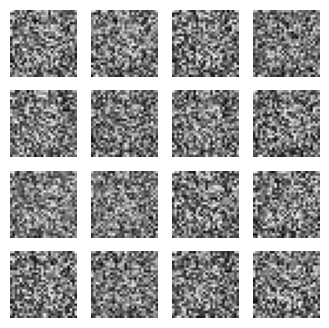

Epoch 2 done


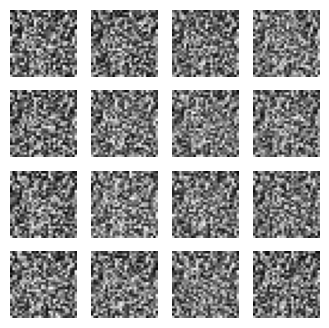

Epoch 3 done


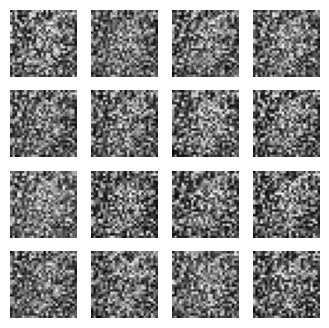

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and normalize MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = x_train[..., tf.newaxis]
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(32)

# Generator
def make_generator():
    return tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.Dense(784, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])

# Discriminator
def make_discriminator():
    return tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])

generator = make_generator()
discriminator = make_discriminator()

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
    noise = tf.random.normal([32, 100])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake = generator(noise, training=True)
        real_out = discriminator(images, training=True)
        fake_out = discriminator(fake, training=True)

        g_loss = loss_fn(tf.ones_like(fake_out), fake_out)
        d_loss_real = loss_fn(tf.ones_like(real_out), real_out)
        d_loss_fake = loss_fn(tf.zeros_like(fake_out), fake_out)
        d_loss = d_loss_real + d_loss_fake

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    gen_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    disc_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

def generate_images():
    noise = tf.random.normal([16, 100])
    predictions = generator(noise, training=False)
    predictions = predictions * 127.5 + 127.5
    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    for i in range(16):
        axs[i // 4, i % 4].imshow(predictions[i, :, :, 0], cmap='gray')
        axs[i // 4, i % 4].axis('off')
    plt.show()

for epoch in range(3):
    for image_batch in train_dataset.take(200):
        train_step(image_batch)
    print(f"Epoch {epoch + 1} done")
    generate_images()

